In [112]:
# ==========================================================
#Imports & Config
# ==========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    auc,
    accuracy_score
)
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

import warnings
warnings.filterwarnings("ignore")

DATA_PATH = "patient_data.csv"
RANDOM_STATE = 42


In [113]:
# ==========================================================
# Load Dataset
# ==========================================================

df = pd.read_csv(DATA_PATH)
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (50000, 9)


,age,gender,diagnosis_code,procedures,lab_result,length_of_stay,prev_admissions,discharge_type,readmitted
0,69,F,D2,1,77.658279,10,3,Home,1
1,32,M,D1,0,111.360511,13,1,Home,0
2,89,M,D1,1,115.286626,6,1,Nursing,1
3,78,M,D1,6,98.750401,6,1,Home,0
4,38,F,D8,3,106.281126,13,3,Home,1


In [114]:



# ==========================================================
# Derived Features
# ==========================================================

# Age groups
df['age_group'] = pd.cut(df['age'], bins=[0,30,50,70,100], labels=[0,1,2,3])

# High lab result flag
df['high_lab'] = (df['lab_result'] > 120).astype(int)

# Patient complexity score
df['complexity_score'] = df['procedures'] + df['prev_admissions']

# Stay * complexity
df['stay_complexity'] = df['length_of_stay'] * df['complexity_score']




Missing Values:
 age                 0
gender              0
diagnosis_code      0
procedures          0
lab_result          0
length_of_stay      0
prev_admissions     0
discharge_type      0
readmitted          0
age_group           0
high_lab            0
complexity_score    0
stay_complexity     0
dtype: int64

Class Distribution (0 = No Readmission, 1 = Readmission):
readmitted
0    0.74752
1    0.25248
Name: proportion, dtype: float64


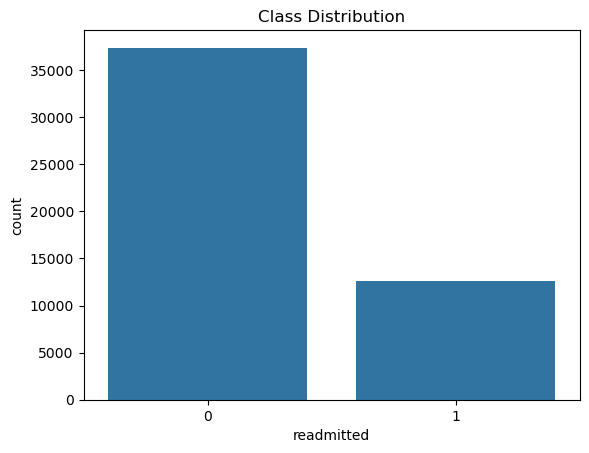

In [115]:
# ==========================================================
# Basic EDA
# ==========================================================

print("\nMissing Values:\n", df.isnull().sum())
print("\nClass Distribution (0 = No Readmission, 1 = Readmission):")
print(df["readmitted"].value_counts(normalize=True))

sns.countplot(x="readmitted", data=df)
plt.title("Class Distribution")
plt.show()



In [116]:
# ==========================================================
# Features & Target
# ==========================================================

X = df.drop("readmitted", axis=1)
y = df["readmitted"]

categorical_features = ["gender", "diagnosis_code", "discharge_type", "age_group"]
numerical_features = [col for col in X.columns if col not in categorical_features]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])



In [117]:
# ==========================================================
# Train / Validation / Test Split
# ==========================================================

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)



Train size: (35000, 12)
Validation size: (7500, 12)
Test size: (7500, 12)


In [118]:
# ==========================================================
# Preprocess & SMOTE
# ==========================================================

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

smote = SMOTE(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = smote.fit_resample(
    X_train_processed, y_train
)

print("After SMOTE class balance:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))



After SMOTE class balance:
readmitted
0    0.5
1    0.5
Name: proportion, dtype: float64


In [119]:
# ==========================================================
# LightGBM Model Training (Using lgb.train)
# ==========================================================

# Convert to LightGBM Dataset
lgb_train = lgb.Dataset(X_train_balanced, label=y_train_balanced)
lgb_val = lgb.Dataset(X_val_processed, label=y_val, reference=lgb_train)

# Parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'scale_pos_weight': y_train_balanced.value_counts()[0] / y_train_balanced.value_counts()[1],
    'seed': RANDOM_STATE,
    'verbose': -1
}

# Train with early stopping
lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)]
)



Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.851297	valid_1's auc: 0.509367
Early stopping, best iteration is:
[22]	training's auc: 0.830063	valid_1's auc: 0.513576


In [120]:
# ==========================================================
# Validation Evaluation
# ==========================================================

y_val_prob = lgb_model.predict(X_val_processed)
y_val_pred = (y_val_prob > 0.5).astype(int)

print("VALIDATION REPORT\n")
print(classification_report(y_val, y_val_pred))

val_auroc = roc_auc_score(y_val, y_val_prob)
print("Validation AUROC:", round(val_auroc, 4))



VALIDATION REPORT

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      5606
           1       0.00      0.00      0.00      1894

    accuracy                           0.75      7500
   macro avg       0.37      0.50      0.43      7500
weighted avg       0.56      0.75      0.64      7500

Validation AUROC: 0.5136


In [121]:
# ==========================================================
# Test Evaluation
# ==========================================================

y_test_prob = lgb_model.predict(X_test_processed)
y_test_pred = (y_test_prob > 0.5).astype(int)

print("TEST REPORT\n")
print(classification_report(y_test, y_test_pred))

test_auroc = roc_auc_score(y_test, y_test_prob)
print("Test AUROC:", round(test_auroc, 4))



TEST REPORT

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      5607
           1       0.00      0.00      0.00      1893

    accuracy                           0.75      7500
   macro avg       0.37      0.50      0.43      7500
weighted avg       0.56      0.75      0.64      7500

Test AUROC: 0.5268


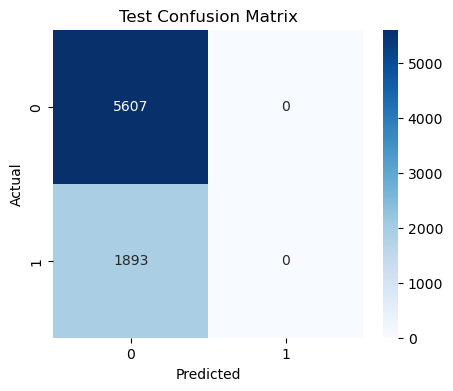

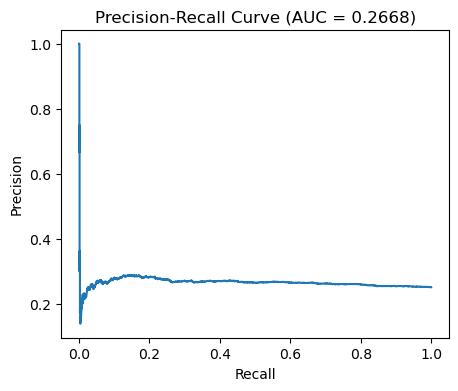

In [122]:
# ==========================================================
#Confusion Matrix
# ==========================================================

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ==========================================================
# Precision-Recall Curve
# ==========================================================

precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(5, 4))
plt.plot(recall, precision)
plt.title(f"Precision-Recall Curve (AUC = {round(pr_auc, 4)})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()



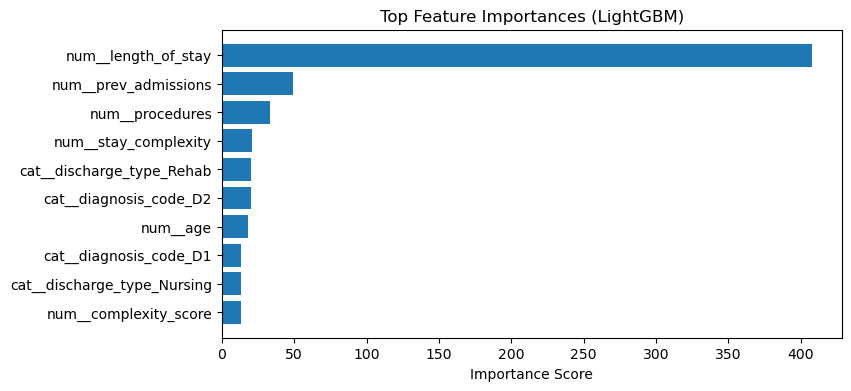

In [123]:
# ==========================================================
# Feature Importance
# ==========================================================

feature_names = preprocessor.get_feature_names_out()
importances = lgb_model.feature_importance()

indices = np.argsort(importances)[-10:]

plt.figure(figsize=(8, 4))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), feature_names[indices])
plt.title("Top Feature Importances (LightGBM)")
plt.xlabel("Importance Score")
plt.show()




In [124]:
# ==========================================================
# Training & Validation Accuracy
# ==========================================================

y_train_pred = (lgb_model.predict(X_train_balanced) > 0.5).astype(int)
train_acc = accuracy_score(y_train_balanced, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print("Training Accuracy:", round(train_acc, 4))
print("Validation Accuracy:", round(val_acc, 4))

Training Accuracy: 0.7828
Validation Accuracy: 0.7475
